<a href="https://colab.research.google.com/github/afrazier01/DS-using-Python-Graduate-Final/blob/main/Data_Science_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Data Science using Python Graduate Final Project***

**Name: Aveontae Frazier**

In this final, a simplified version of the Kaggle competition below was completed.

*   https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/data

## Dataset Description

The Healthy Brain Network (HBN) dataset is a clinical sample of about five-thousand 5-22 year-olds who have undergone both clinical and research screenings. The objective of the HBN study is to find biological markers that will improve the diagnosis and treatment of mental health and learning disorders from an objective biological perspective. Two elements of this study are being used for this competition: physical activity data (wrist-worn accelerometer data, fitness assessments and questionnaires) and internet usage behavior data. The goal of this competition is to predict from this data a participant's Severity Impairment Index (`sii`), a standard measure of problematic internet use.

Note that this is a Code Competition, in which the actual test set is hidden. In this public version, we give some sample data in the correct format to help you author your solutions. The full test set comprises about 3800 instances.

The competition data is compiled into two sources, parquet files containing the accelerometer (actigraphy) series and csv files containing the remaining tabular data. The majority of measures are missing for most participants. In particular, the target sii is missing for a portion of the participants in the training set. You may wish to apply non-supervised learning techniques to this data. The sii value is present for all instances in the test set.



### HBN Instruments

The tabular data in train.csv and test.csv comprises measurements from a variety of instruments. The fields within each instrument are described in data_dictionary.csv. These instruments are:


*   `Demographics` - Information about age and sex of participants.
*   `Internet Use` - Number of hours of using computer/internet per day.
*   `Children's Global Assessment Scale` - Numeric scale used by mental health clinicians to rate the general functioning of youths under the age of 18.
*   `Physical Measures` - Collection of blood pressure, heart rate, height, weight and waist, and hip measurements.
*   `FitnessGram Vitals and Treadmill` - Measurements of cardiovascular fitness assessed using the NHANES treadmill protocol.
*   `Bio-electric Impedance Analysis` - Measure of key body composition elements, including BMI, fat, muscle, and water content.
*   `Physical Activity Questionnaire` - Information about children's participation in vigorous activities over the last 7 days.
*   `Sleep Disturbance Scale` - Scale to categorize sleep disorders in children.
*   `Actigraphy` - Objective measure of ecological physical activity through a research-grade biotracker.
*   `Parent-Child Internet Addiction Test` - 20-item scale that measures characteristics and behaviors associated with compulsive use of the Internet including compulsivity, escapism, and dependency.   

Note in particular the field `PCIAT-PCIAT_Total`. The target sii for this competition is derived from this field as described in the data dictionary: 0 for None, 1 for Mild, 2 for Moderate, and 3 for Severe. Additionally, each participant has been assigned a unique identifier id.

### Actigraphy Files and Field Descriptions

During their participation in the HBN study, some participants were given an accelerometer to wear for up to 30 days continually while at home and going about their regular daily lives.

*   `id` - The patient identifier corresponding to the id field in train/test.csv.
*   `step` - An integer timestep for each observation within a series.
*   `X, Y, Z` - Measure of acceleration, in g, experienced by the wrist-worn watch along each standard axis.
*   `enmo` - As calculated and described by the wristpy package, ENMO is the Euclidean Norm Minus One of all accelerometer signals (along each of the x-, y-, and z-axis, measured in g-force) with negative values rounded to zero. Zero values are indicative of periods of no motion. While no standard measure of acceleration exists in this space, this is one of the several commonly computed features.
*   `anglez` - As calculated and described by the wristpy package, Angle-Z is a metric derived from individual accelerometer components and refers to the angle of the arm relative to the horizontal plane.
*   `non-wear_flag` - A flag (0: watch is being worn, 1: the watch is not worn) to help determine periods when the watch has been removed, based on the GGIR definition, which uses the standard deviation and range of the accelerometer data.
*   `light` - Measure of ambient light in lux. See ​​here for details.
*   `battery_voltage` - A measure of the battery voltage in mV.
*   `time_of_day` - Time of day representing the start of a 5s window that the data has been sampled over, with format %H:%M:%S.%9f.
*   `weekday` - The day of the week, coded as an integer with 1 being Monday and 7 being Sunday.
*   `quarter` - The quarter of the year, an integer from 1 to 4.
*   `relative_date_PCIAT` - The number of days (integer) since the PCIAT test was administered (negative days indicate that the actigraphy data has been collected before the test was administered).














In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Import required libs
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import os
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Baseline Model Results

Using the starter code provided, the following yields a baseline performance.

In [ ]:
# Load train DataFrame
train_df = pd.read_csv('/content/drive/MyDrive/OPIM_5512/train.csv')

# the target is sii (last column)
train_df.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Predictors with varying levels of quality
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

In [ ]:
# Recode target variable
train_df['sii'].value_counts()

,count
sii,
0.0,1594
1.0,730
2.0,378
3.0,34


In [ ]:
# Recategorize 'sii' to 0.0 and 1.0
train_df['sii'] = train_df['sii'].apply(lambda x: 0.0 if x == 0.0 else 1.0)

# Check the value counts
train_df['sii'].value_counts()

,count
sii,
1.0,2366
0.0,1594


In [ ]:
# Ensure sure all values are filled in
print(train_df.shape)
train_df = train_df.dropna(subset=['sii'])
print(train_df.shape)

(3960, 82)
(3960, 82)


In [ ]:
parquet_dir = '/content/drive/MyDrive/OPIM_5512/series_train.parquet'

# Initialize a DataFrame to store mean values and labels
data_by_id = {}
label_list = []

# Process each parquet file to extract mean values
for idx, row in train_df.iterrows():
    file_id = row['id']
    parquet_file_path = os.path.join(parquet_dir, f"id={file_id}", "part-0.parquet")

    # Check if the file exists
    if not os.path.exists(parquet_file_path):
        pass
        continue

    try:
        # Load parquet data for current ID
        data = pq.read_table(parquet_file_path).to_pandas()

        # Check if data is loaded properly
        if data.empty:
            print(f"No data in file: {parquet_file_path}")
            continue

        # Compute mean values for feature columns (exclude 'id' and 'sii')
        feature_columns = [col for col in data.columns if col not in ['id', 'sii']]

        # Check if feature columns exist in the data before calculating means
        if feature_columns:
            mean_values = data[feature_columns].mean().values

            # Store mean values and label
            data_by_id[file_id] = mean_values
            label_list.append(row['sii'])

    except:
        pass

In [ ]:
# Convert the mean values and labels into a DataFrame
mean_values_df = pd.DataFrame.from_dict(data_by_id, orient='index')
mean_values_df['sii'] = label_list
mean_values_df.reset_index(inplace=True)
mean_values_df.rename(columns={'index': 'id'}, inplace=True)
mean_values_df.head()

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,sii
0,00115b9f,21664.5,-0.316384,0.016009,-0.167890,0.047388,-10.580416,0.000000,42.296310,4053.579102,5.046215e+13,4.470182,3.0,53.201683,1.0
1,001f3379,198197.5,-0.004272,0.016859,-0.631731,0.011926,-55.630768,0.655708,16.771982,3838.189453,4.321212e+13,3.909848,3.0,79.435593,1.0
2,00f332d1,207191.5,0.208036,0.057094,0.141550,0.030255,6.687338,0.171246,66.563408,3848.583252,4.318680e+13,3.832677,2.0,26.152903,1.0
3,01085eb3,185477.5,-0.343396,-0.055826,-0.254433,0.032946,-17.589041,0.035210,17.800735,3849.649414,4.338433e+13,3.963284,4.0,49.910686,0.0
4,012cadd8,48523.5,0.018670,0.071660,-0.061682,0.058280,-5.059758,0.000000,54.893394,3974.910645,4.343573e+13,4.168412,4.0,-1.168288,0.0


In [ ]:
mean_values_df.shape # this is less than the rows in train_df

(996, 15)

In [ ]:
mean_values_df['sii'].value_counts()

,count
sii,
0.0,583
1.0,413


In [ ]:
# Ensure there are no missing values in sii that correspond to train.csv
mean_values_df['sii'].isna().sum()

0

In [ ]:
# Prepare data for training
X = mean_values_df.drop(columns=['sii'])
y = mean_values_df['sii']

# Split the data into training and testing sets
# note that no demographic info was used!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.head()

,id,0,1,2,3,4,5,6,7,8,9,10,11,12
626,a0522c83,200315.5,-0.505789,-0.069706,0.013336,0.025508,1.611984,0.03190,21.629858,3850.230225,4.330124e+13,4.012999,1.000000,18.649494
307,4a4a0f78,190155.5,0.121610,0.032871,0.152650,0.034276,10.249540,0.00000,22.919933,3814.928467,4.320668e+13,3.897484,1.000000,88.265633
662,a8b0428d,692.5,-0.275158,0.259596,0.317515,0.029915,20.623983,0.00000,25.377674,3887.100342,4.550378e+13,5.284993,3.605339,249.643585
394,6282e693,68514.0,-0.256388,-0.066792,-0.174034,0.086394,-12.297556,0.00000,87.192596,3991.940674,4.818751e+13,3.682242,4.000000,19.846697
644,a4530b41,203633.5,0.016842,-0.047838,0.140291,0.047017,8.838480,0.04807,17.082886,3839.499756,4.331332e+13,4.200448,2.318395,12.925396


In [ ]:
# convert from series to dataframe so we can add a column
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [ ]:
y_train['id'] = X_train['id']
y_test['id'] = X_test['id']

In [ ]:
y_train.head()

,sii,id
626,1.0,a0522c83
307,1.0,4a4a0f78
662,1.0,a8b0428d
394,0.0,6282e693
644,0.0,a4530b41


In [ ]:
X_train.shape

(796, 14)

In [ ]:
X_test.shape

(200, 14)

In [ ]:
y_test.shape

(200, 2)

In [ ]:
y_train.shape

(796, 2)

In [ ]:
# X_train.to_csv('/content/drive/MyDrive/OPIM_5512/X_train_F24_withID.csv')
# X_test.to_csv('/content/drive/MyDrive/OPIM_5512/X_test_F24_withID.csv')
# y_train.to_csv('/content/drive/MyDrive/OPIM_5512/y_train_F24_withID.csv')
# y_test.to_csv('/content/drive/MyDrive/OPIM_5512/y_test_F24_withID.csv')

In [ ]:
#drop IDs
X_train = X_train.drop(columns=['id'])
X_test = X_test.drop(columns=['id'])
y_train = y_train.drop(columns=['id'])
y_test = y_test.drop(columns=['id'])

In [ ]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
626,200315.5,-0.505789,-0.069706,0.013336,0.025508,1.611984,0.03190,21.629858,3850.230225,4.330124e+13,4.012999,1.000000,18.649494
307,190155.5,0.121610,0.032871,0.152650,0.034276,10.249540,0.00000,22.919933,3814.928467,4.320668e+13,3.897484,1.000000,88.265633
662,692.5,-0.275158,0.259596,0.317515,0.029915,20.623983,0.00000,25.377674,3887.100342,4.550378e+13,5.284993,3.605339,249.643585
394,68514.0,-0.256388,-0.066792,-0.174034,0.086394,-12.297556,0.00000,87.192596,3991.940674,4.818751e+13,3.682242,4.000000,19.846697
644,203633.5,0.016842,-0.047838,0.140291,0.047017,8.838480,0.04807,17.082886,3839.499756,4.331332e+13,4.200448,2.318395,12.925396


In [ ]:
y_train.head()

,sii
626,1.0
307,1.0
662,1.0
394,0.0
644,0.0


In [ ]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Display the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.76      0.69       120
         1.0       0.50      0.36      0.42        80

    accuracy                           0.60       200
   macro avg       0.57      0.56      0.56       200
weighted avg       0.58      0.60      0.58       200



 # Exploratory Data Analysis

 Our demographic information EDA was conducted in [this notebook](https://colab.research.google.com/drive/1T4KNmHwv_hJysJ0fEqu12BmEP_iG79eX?usp=sharing).

 Our processed feature-engineered parquet files EDA was conducted in [this notebook](https://colab.research.google.com/drive/1tI_FU9BbQKMIeeVS4qoc8qVRvIy9iv9O?usp=sharing#scrollTo=EM3I0zWlQSkd).

# Modeling using minimal engineered features

## TSFresh for Automated Feature Engineering

In [ ]:
# Install tsfresh
!pip install tsfresh
!pip install dask[dataframe]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 4.5 MB/s eta 0:00:00


In [ ]:
import os
import pyarrow.parquet as pq
import pandas as pd
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh.feature_extraction import MinimalFCParameters

train_df = pd.read_csv('/content/drive/MyDrive/OPIM_5512/train.csv')

# Define the directory where your parquet files are located
parquet_dir = '/content/drive/MyDrive/OPIM_5512/series_train.parquet'

# Initialize a DataFrame to store the extracted features and labels
extracted_features = []
id_list = []  # To store the ids corresponding to the features
label_list = []

# Define minimal feature extraction settings
minimal_fc_parameters = MinimalFCParameters()

# Process each parquet file to extract features using tsfresh
for idx, row in train_df.iterrows():
    file_id = row['id']
    parquet_file_path = os.path.join(parquet_dir, f"id={file_id}", "part-0.parquet")

    # Check if the file exists
    if not os.path.exists(parquet_file_path):
        continue

    try:
        # Load parquet data for current ID
        data = pq.read_table(parquet_file_path).to_pandas()

        # Check if data is loaded properly
        if data.empty:
            print(f"No data in file: {parquet_file_path}")
            continue

        # Ensure the 'id' column is present for tsfresh
        data['id'] = file_id

        # Create a time index if it doesn't exist
        if 'time' not in data.columns:
            data['time'] = range(len(data))

        # Extract features using tsfresh with minimal settings
        features = extract_features(
            data,
            column_id='id',
            column_sort='step',
            default_fc_parameters=minimal_fc_parameters
        )

        # Append the extracted features
        extracted_features.append(features)

        # Store the corresponding id and label
        id_list.append(file_id)
        label_list.append(row['sii'])

    except Exception as e:
        print(f"Error processing file {file_id}: {e}")

# Combine all extracted features into a single DataFrame
features_df = pd.concat(extracted_features, axis=0).reset_index(drop=True)

# Handle missing values in the combined DataFrame
features_df.fillna(0, inplace=True)  # Replace missing values with 0 (or customize based on your strategy)

# Add the 'id' and 'sii' columns to the features DataFrame
features_df['id'] = id_list
features_df['sii'] = label_list

# Display the final DataFrame
print(features_df.head())

Feature Extraction: 100%|██████████| 13/13 [00:00<00:00, 33.85it/s]


   X__sum_values  X__median   X__mean  X__length  X__standard_deviation  \
0  -13708.897461  -0.366849 -0.316384    43330.0               0.453660   
1   -1693.504150  -0.020622 -0.004272   396396.0               0.351544   
2   86206.828125   0.194404  0.208036   414384.0               0.486976   
3 -127384.890625  -0.473294 -0.343396   370956.0               0.516126   
4    1811.900879   0.036376  0.018670    97048.0               0.595248   

   X__variance  X__root_mean_square  X__maximum  X__absolute_maximum  \
0     0.205807             0.553087    1.507865             1.746094   
1     0.123583             0.351570    1.034351             1.038711   
2     0.237146             0.529552    1.666465             1.952594   
3     0.266386             0.619925    1.000692             2.284304   
4     0.354320             0.595541    3.341210             3.341210   

   X__minimum  ...  weekday__mean  weekday__length  \
0   -1.746094  ...       4.470182          43330.0   
1   -1.0

In [ ]:
print("%.0f total features returned. \n" % (features_df.shape[1]-2)) #minus two for id and sii

print("Columns:")
[f"{column_num} - {column}" for column_num, column in enumerate(features_df.columns, start=1)]

130 total features returned. 

Columns:


['1 - X__sum_values',
 '2 - X__median',
 '3 - X__mean',
 '4 - X__length',
 '5 - X__standard_deviation',
 '6 - X__variance',
 '7 - X__root_mean_square',
 '8 - X__maximum',
 '9 - X__absolute_maximum',
 '10 - X__minimum',
 '11 - Y__sum_values',
 '12 - Y__median',
 '13 - Y__mean',
 '14 - Y__length',
 '15 - Y__standard_deviation',
 '16 - Y__variance',
 '17 - Y__root_mean_square',
 '18 - Y__maximum',
 '19 - Y__absolute_maximum',
 '20 - Y__minimum',
 '21 - Z__sum_values',
 '22 - Z__median',
 '23 - Z__mean',
 '24 - Z__length',
 '25 - Z__standard_deviation',
 '26 - Z__variance',
 '27 - Z__root_mean_square',
 '28 - Z__maximum',
 '29 - Z__absolute_maximum',
 '30 - Z__minimum',
 '31 - enmo__sum_values',
 '32 - enmo__median',
 '33 - enmo__mean',
 '34 - enmo__length',
 '35 - enmo__standard_deviation',
 '36 - enmo__variance',
 '37 - enmo__root_mean_square',
 '38 - enmo__maximum',
 '39 - enmo__absolute_maximum',
 '40 - enmo__minimum',
 '41 - anglez__sum_values',
 '42 - anglez__median',
 '43 - anglez__

## Process data in preparation of modeling

In [ ]:
# Read in processed partitioned data for IDs, omit mean values
X_train = pd.read_csv('/content/drive/MyDrive/OPIM_5512/X_train_F24_withID.csv', usecols=['id'])
X_test = pd.read_csv('/content/drive/MyDrive/OPIM_5512/X_test_F24_withID.csv', usecols=['id'])
y_train = pd.read_csv('/content/drive/MyDrive/OPIM_5512/y_train_F24_withID.csv', usecols=['id', 'sii'])
y_test = pd.read_csv('/content/drive/MyDrive/OPIM_5512/y_test_F24_withID.csv', usecols=['id', 'sii'])

X_train.head() #IDs

,id
0,a0522c83
1,4a4a0f78
2,a8b0428d
3,6282e693
4,a4530b41


### Merge Engineered Features (features_df) to X_train and X_test IDs

In [ ]:
# Merge X_train with final_df
X_train = X_train.merge(features_df, on='id', how='left', suffixes=('', '_final'))

# Merge X_test with final_df
X_test = X_test.merge(features_df, on='id', how='left', suffixes=('', '_final'))

X_train.head()

,id,X__sum_values,X__median,X__mean,X__length,X__standard_deviation,X__variance,X__root_mean_square,X__maximum,X__absolute_maximum,...,weekday__median,weekday__mean,weekday__length,weekday__standard_deviation,weekday__variance,weekday__root_mean_square,weekday__maximum,weekday__absolute_maximum,weekday__minimum,sii
0,a0522c83,-202635.296875,-0.716905,-0.505789,400632.0,0.557440,0.310739,0.752703,1.173187,2.106928,...,4.0,4.012999,400632.0,1.916770,3.674006,4.447266,7.0,7.0,1.0,2.0
1,4a4a0f78,46249.667969,0.182309,0.121610,380312.0,0.579833,0.336206,0.592449,7.935687,7.935687,...,4.0,3.897484,380312.0,2.010898,4.043709,4.385669,7.0,7.0,1.0,2.0
2,a8b0428d,-381.369232,-0.458828,-0.275158,1386.0,0.386449,0.149343,0.474399,1.024297,1.024297,...,5.0,5.284993,1386.0,0.774982,0.600597,5.341512,7.0,7.0,1.0,1.0
3,6282e693,-35132.593750,-0.394569,-0.256388,137029.0,0.542227,0.294010,0.599787,1.463910,1.700533,...,4.0,3.682242,137029.0,1.699524,2.888383,4.055526,7.0,7.0,1.0,0.0
4,a4530b41,6859.332031,0.026158,0.016842,407268.0,0.555293,0.308351,0.555549,8.022779,8.022779,...,4.0,4.200448,407268.0,2.042359,4.171229,4.670652,7.0,7.0,1.0,0.0


In [ ]:
print(X_train.shape)
print(X_test.shape)

(796, 132)
(200, 132)


### Write/Read Processed TSFresh features

In [ ]:
# Write to csv
# X_train.to_csv('/content/drive/MyDrive/OPIM_5512/X_train_F24_withID_withTSFresh.csv')
# X_test.to_csv('/content/drive/MyDrive/OPIM_5512/X_test_F24_withID_withTSFresh.csv')
# y_train.to_csv('/content/drive/MyDrive/OPIM_5512/y_train_F24_withID_withTSFresh.csv')
# y_test.to_csv('/content/drive/MyDrive/OPIM_5512/y_test_F24_withID_withTSFresh.csv')

# # Read-in processed features
X_train = pd.read_csv('/content/drive/MyDrive/OPIM_5512/X_train_F24_withID_withTSFresh.csv')
X_test = pd.read_csv('/content/drive/MyDrive/OPIM_5512/X_test_F24_withID_withTSFresh.csv')
y_train = pd.read_csv('/content/drive/MyDrive/OPIM_5512/y_train_F24_withID_withTSFresh.csv')
y_test = pd.read_csv('/content/drive/MyDrive/OPIM_5512/y_test_F24_withID_withTSFresh.csv')

# # Remove junk columns and sii
X_train = X_train.drop(columns=['Unnamed: 0', 'sii'])
y_train = y_train.drop(columns=['Unnamed: 0'])
X_test = X_test.drop(columns=['Unnamed: 0', 'sii'])
y_test = y_test.drop(columns=['Unnamed: 0'])

X_train.head()

,id,X__sum_values,X__median,X__mean,X__length,X__standard_deviation,X__variance,X__root_mean_square,X__maximum,X__absolute_maximum,...,weekday__sum_values,weekday__median,weekday__mean,weekday__length,weekday__standard_deviation,weekday__variance,weekday__root_mean_square,weekday__maximum,weekday__absolute_maximum,weekday__minimum
0,a0522c83,-202635.296875,-0.716905,-0.505789,400632.0,0.557440,0.310739,0.752703,1.173187,2.106928,...,1607736.0,4.0,4.012999,400632.0,1.916770,3.674006,4.447266,7.0,7.0,1.0
1,4a4a0f78,46249.667969,0.182309,0.121610,380312.0,0.579833,0.336206,0.592449,7.935687,7.935687,...,1482260.0,4.0,3.897484,380312.0,2.010898,4.043709,4.385669,7.0,7.0,1.0
2,a8b0428d,-381.369232,-0.458828,-0.275158,1386.0,0.386449,0.149343,0.474399,1.024297,1.024297,...,7325.0,5.0,5.284993,1386.0,0.774982,0.600597,5.341512,7.0,7.0,1.0
3,6282e693,-35132.593750,-0.394569,-0.256388,137029.0,0.542227,0.294010,0.599787,1.463910,1.700533,...,504574.0,4.0,3.682242,137029.0,1.699524,2.888383,4.055526,7.0,7.0,1.0
4,a4530b41,6859.332031,0.026158,0.016842,407268.0,0.555293,0.308351,0.555549,8.022779,8.022779,...,1710708.0,4.0,4.200448,407268.0,2.042359,4.171229,4.670652,7.0,7.0,1.0


In [ ]:
y_train.head()

,sii,id
0,1.0,a0522c83
1,1.0,4a4a0f78
2,1.0,a8b0428d
3,0.0,6282e693
4,0.0,a4530b41


In [ ]:
pd.set_option('display.max_info_columns', X_train.columns.nunique()) #print each column
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796 entries, 0 to 795
Data columns (total 131 columns):
 #    Column                                   Non-Null Count  Dtype  
---   ------                                   --------------  -----  
 0    id                                       796 non-null    object 
 1    X__sum_values                            796 non-null    float64
 2    X__median                                796 non-null    float64
 3    X__mean                                  796 non-null    float64
 4    X__length                                796 non-null    float64
 5    X__standard_deviation                    796 non-null    float64
 6    X__variance                              796 non-null    float64
 7    X__root_mean_square                      796 non-null    float64
 8    X__maximum                               796 non-null    float64
 9    X__absolute_maximum                      796 non-null    float64
 10   X__minimum                          

### Remove variables with High Correlation to `SII`

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/OPIM_5512/train.csv')

train_df.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Check which variables are perfectly/highly correlated with sii
threshold = 0.6 # Initial threshold

# Select numerical columns
numerical_cols = train_df.select_dtypes(include=['float64', 'int64'])

# Compute correlations with 'sii'
correlation_with_sii = numerical_cols.corr()['sii']
high_correlation = correlation_with_sii[correlation_with_sii.abs() > threshold].sort_values(ascending=False)

print(f"Variables with high correlation to 'sii' (|correlation| > {threshold}):")
print(high_correlation)

Variables with high correlation to 'sii' (|correlation| > 0.6):
sii                  1.000000
PCIAT-PCIAT_Total    0.899681
PCIAT-PCIAT_15       0.751399
PCIAT-PCIAT_18       0.731112
PCIAT-PCIAT_17       0.729867
PCIAT-PCIAT_05       0.722722
PCIAT-PCIAT_13       0.705679
PCIAT-PCIAT_20       0.703013
PCIAT-PCIAT_16       0.698566
PCIAT-PCIAT_08       0.695458
PCIAT-PCIAT_03       0.694736
PCIAT-PCIAT_02       0.694597
PCIAT-PCIAT_10       0.689972
PCIAT-PCIAT_19       0.683293
PCIAT-PCIAT_14       0.675953
PCIAT-PCIAT_09       0.660485
PCIAT-PCIAT_06       0.645596
PCIAT-PCIAT_01       0.617883
PCIAT-PCIAT_11       0.609964
Name: sii, dtype: float64


Perhaps, `PCIAT` is leaking data.

Based on the following Kaggle note, I will remove each `PCIAT`:

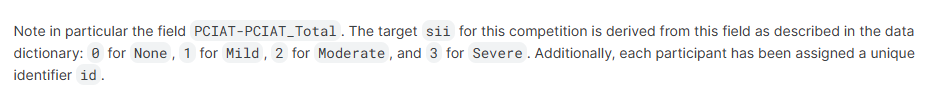

In [ ]:
train_df = train_df.drop(columns=[ 'sii']) #drop sii

# Drop all columns starting with 'PCIAT'
train_df = train_df.loc[:, ~train_df.columns.str.startswith("PCIAT")]

# Verify the columns were removed
pd.set_option('display.max_info_columns', 200)  # Increase
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 59 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

### Create dummy variables

In [ ]:
# Automatically identify categorical columns based on their data type
categorical_cols = train_df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
categorical_cols.remove('id') #exclude id

# Print each categorical demographic feature
print(f"{len(categorical_cols)} Categorical Variables (excluding 'id'):")
for column in categorical_cols:
  print(column)

# Convert categorical columns to dummy variables
train_df_encoded = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True, dtype=float)

# Display the first few rows of the encoded dataframe
train_df_encoded.head()

10 Categorical Variables (excluding 'id'):
Basic_Demos-Enroll_Season
CGAS-Season
Physical-Season
Fitness_Endurance-Season
FGC-Season
BIA-Season
PAQ_A-Season
PAQ_C-Season
SDS-Season
PreInt_EduHx-Season


,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,...,PAQ_A-Season_Winter,PAQ_C-Season_Spring,PAQ_C-Season_Summer,PAQ_C-Season_Winter,SDS-Season_Spring,SDS-Season_Summer,SDS-Season_Winter,PreInt_EduHx-Season_Spring,PreInt_EduHx-Season_Summer,PreInt_EduHx-Season_Winter
0,00008ff9,5,0,51.0,16.877316,46.0,50.8,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,000fd460,9,0,NaN,14.035590,48.0,46.0,22.0,75.0,70.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,00105258,10,1,71.0,16.648696,56.5,75.6,NaN,65.0,94.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,00115b9f,9,0,71.0,18.292347,56.0,81.6,NaN,60.0,97.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0016bb22,18,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
dummies = train_df_encoded.iloc[:, 49:].columns #dummy variables

print(f"{len(dummies)} Dummy Variables were created: \n")
for dummy in dummies:
  print(dummy)

30 Dummy Variables were created: 

Basic_Demos-Enroll_Season_Spring
Basic_Demos-Enroll_Season_Summer
Basic_Demos-Enroll_Season_Winter
CGAS-Season_Spring
CGAS-Season_Summer
CGAS-Season_Winter
Physical-Season_Spring
Physical-Season_Summer
Physical-Season_Winter
Fitness_Endurance-Season_Spring
Fitness_Endurance-Season_Summer
Fitness_Endurance-Season_Winter
FGC-Season_Spring
FGC-Season_Summer
FGC-Season_Winter
BIA-Season_Spring
BIA-Season_Summer
BIA-Season_Winter
PAQ_A-Season_Spring
PAQ_A-Season_Summer
PAQ_A-Season_Winter
PAQ_C-Season_Spring
PAQ_C-Season_Summer
PAQ_C-Season_Winter
SDS-Season_Spring
SDS-Season_Summer
SDS-Season_Winter
PreInt_EduHx-Season_Spring
PreInt_EduHx-Season_Summer
PreInt_EduHx-Season_Winter


### Join Accelerometer and Demographic Data

In [ ]:
# Merge the encoded train features with X_train based on 'id'
X_train_merged = X_train.merge(train_df_encoded, on='id', how='left')

# Merge the encoded test features with X_test based on 'id'
X_test_merged = X_test.merge(train_df_encoded, on='id', how='left')

In [ ]:
#drop IDs for modeling
X_train = X_train_merged.drop(columns=['id'], axis=1)
X_test = X_test_merged.drop(columns=['id'], axis=1)
y_train.drop('id', axis=1, inplace=True)
y_test.drop('id', axis=1, inplace=True)

X_train.head()

,X__sum_values,X__median,X__mean,X__length,X__standard_deviation,X__variance,X__root_mean_square,X__maximum,X__absolute_maximum,X__minimum,...,PAQ_A-Season_Winter,PAQ_C-Season_Spring,PAQ_C-Season_Summer,PAQ_C-Season_Winter,SDS-Season_Spring,SDS-Season_Summer,SDS-Season_Winter,PreInt_EduHx-Season_Spring,PreInt_EduHx-Season_Summer,PreInt_EduHx-Season_Winter
0,-202635.296875,-0.716905,-0.505789,400632.0,0.557440,0.310739,0.752703,1.173187,2.106928,-2.106928,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,46249.667969,0.182309,0.121610,380312.0,0.579833,0.336206,0.592449,7.935687,7.935687,-7.919588,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-381.369232,-0.458828,-0.275158,1386.0,0.386449,0.149343,0.474399,1.024297,1.024297,-0.996849,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-35132.593750,-0.394569,-0.256388,137029.0,0.542227,0.294010,0.599787,1.463910,1.700533,-1.700533,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,6859.332031,0.026158,0.016842,407268.0,0.555293,0.308351,0.555549,8.022779,8.022779,-1.224444,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
X_columns = X_train.columns

# Print each column name
print(f"There are {len(X_columns)} columns.\n")
for col in X_columns:
    print(col)

There are 208 columns.

X__sum_values
X__median
X__mean
X__length
X__standard_deviation
X__variance
X__root_mean_square
X__maximum
X__absolute_maximum
X__minimum
Y__sum_values
Y__median
Y__mean
Y__length
Y__standard_deviation
Y__variance
Y__root_mean_square
Y__maximum
Y__absolute_maximum
Y__minimum
Z__sum_values
Z__median
Z__mean
Z__length
Z__standard_deviation
Z__variance
Z__root_mean_square
Z__maximum
Z__absolute_maximum
Z__minimum
enmo__sum_values
enmo__median
enmo__mean
enmo__length
enmo__standard_deviation
enmo__variance
enmo__root_mean_square
enmo__maximum
enmo__absolute_maximum
enmo__minimum
anglez__sum_values
anglez__median
anglez__mean
anglez__length
anglez__standard_deviation
anglez__variance
anglez__root_mean_square
anglez__maximum
anglez__absolute_maximum
anglez__minimum
light__sum_values
light__median
light__mean
light__length
light__standard_deviation
light__variance
light__root_mean_square
light__maximum
light__absolute_maximum
light__minimum
non-wear_flag__sum_values
no

### Preprocessing

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# # Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

pd.DataFrame(X_train_scaled, columns=X_columns)

,X__sum_values,X__median,X__mean,X__length,X__standard_deviation,X__variance,X__root_mean_square,X__maximum,X__absolute_maximum,X__minimum,...,PAQ_A-Season_Winter,PAQ_C-Season_Spring,PAQ_C-Season_Summer,PAQ_C-Season_Winter,SDS-Season_Spring,SDS-Season_Summer,SDS-Season_Winter,PreInt_EduHx-Season_Spring,PreInt_EduHx-Season_Summer,PreInt_EduHx-Season_Winter
0,0.074182,0.012028,0.115814,0.529211,0.782740,0.624226,1.000000,0.101942,0.193355,0.744441,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.660520,0.667305,0.661939,0.502307,0.815646,0.675486,0.779739,0.988581,0.985709,0.015209,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.550664,0.200094,0.316569,0.000608,0.531470,0.299364,0.617487,0.082421,0.046184,0.883707,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.468795,0.246921,0.332908,0.180200,0.760384,0.590552,0.789826,0.140059,0.138111,0.795425,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.567722,0.553514,0.570744,0.537997,0.779585,0.619418,0.729022,1.000000,0.997548,0.855154,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,0.430134,0.464913,0.441850,0.518788,0.388125,0.166762,0.401579,0.079754,0.044688,0.881644,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
792,0.407299,0.290047,0.400073,0.451142,0.859245,0.746512,0.838646,0.396181,0.371497,0.628735,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
793,0.542104,0.122610,0.128997,0.009607,0.517924,0.285194,0.816094,0.078327,0.129039,0.803797,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
794,0.538708,0.522399,0.543842,0.512528,0.767778,0.601586,0.717876,0.084100,0.148659,0.785690,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Modeling

Using my TPOT pipeline

In [ ]:
from xgboost import XGBClassifier

clf = XGBClassifier(
    learning_rate=0.1,
    max_depth=1,
    min_child_weight=16,
    n_estimators=125,
    n_jobs=1,
    subsample=0.70,
    verbosity=0,
    random_state=42
)

# Fit the Model
clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_train = clf.predict(X_train_scaled)
y_pred_test = clf.predict(X_test_scaled)

### Results

Confusion matrix and classsification report

In [ ]:
from sklearn.metrics import confusion_matrix

#train confusion matrix
confusion_matrix(y_train, y_pred_train)

array([[387,  76],
       [112, 221]])

In [ ]:
#test confusion matrix
confusion_matrix(y_test, y_pred_test)

array([[96, 24],
       [29, 51]])

In [ ]:
# Display the classification report
print("Classification Report - Train:")
print(classification_report(y_train, y_pred_train))
print("\nClassification Report - Test:")
print(classification_report(y_test, y_pred_test))

Classification Report - Train:
              precision    recall  f1-score   support

         0.0       0.78      0.84      0.80       463
         1.0       0.74      0.66      0.70       333

    accuracy                           0.76       796
   macro avg       0.76      0.75      0.75       796
weighted avg       0.76      0.76      0.76       796


Classification Report - Test:
              precision    recall  f1-score   support

         0.0       0.77      0.80      0.78       120
         1.0       0.68      0.64      0.66        80

    accuracy                           0.73       200
   macro avg       0.72      0.72      0.72       200
weighted avg       0.73      0.73      0.73       200



In [ ]:
# Verify your shape of the train and test partitions to ensure there is no data leakage!
print(X_train_scaled.shape,
      X_test_scaled.shape)

(796, 208) (200, 208)


## Interpretability

### Permutation Importance

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(clf, X_test_scaled, y_test,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

Top 5 Important Features:
PreInt_EduHx-computerinternet_hoursday
Physical-Height
relative_date_PCIAT__minimum
BIA-BIA_LDM
light__maximum




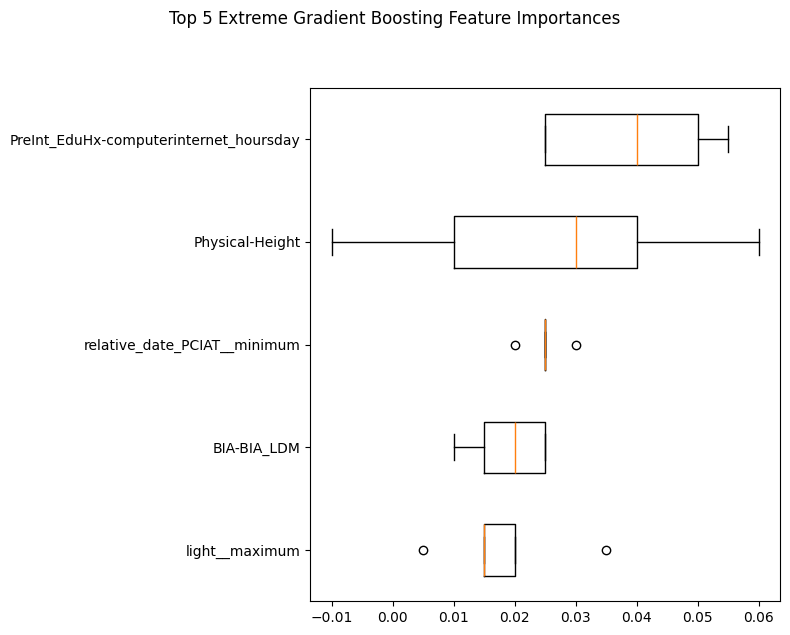

In [ ]:
# Get indices of top 5 important features
top_n = 5
top_features_idx = perm_sorted_idx[-top_n:]  # Last 'top_n' features

# Filter for plotting
filtered_importances = result.importances[top_features_idx]
filtered_labels = np.array(X_columns)[top_features_idx]

# Look at feature names that are flagged as most important
print(f"Top {top_n} Important Features:")
for label in filtered_labels[::-1]:
  print(label)
print("\n")

# Plot top 5 features
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
ax1.boxplot(filtered_importances.T, vert=False, labels=filtered_labels)
fig.suptitle(f'Top {top_n} Extreme Gradient Boosting Feature Importances', y=1.05)
fig.tight_layout()
plt.show()

The box plots reveal a mix of demographic and feature-engineered times series data. The most important features for predicting `SII` come from the following categories:

`Internet Use (PreInt_EduHx)`: Number of hours of using computer/internet per day.

`Physical Measures`: Collection of blood pressure, heart rate, height, weight and waist, and hip measurements.

`Relative_date_PCIAT`: The number of days (*integer*) since the parent-child internet addiction (`PCIAT`) test was administered.

`Bio-electric Impedance Analysis (BIA)`: Measure of key body composition elements, including BMI, fat, muscle, and water content.

`Light`: Measure of ambient light in lux.

According to the data dictionary:
1.   `PreInt_EduHx-computerinternet_hoursday`: Hours of using computer/internet. (*0=Less than 1h/day, 1=Around 1h/day, 2=Around 2hs/day, 3=More than 3hs/day*)
2.   `Physical-Height`: Height (in). (*float*)
3.   `relative_date_PCIAT__minimum`: Engineered `relative_date_PCIAT` feature. (*int*)
4.   `BIA-BIA_LDM`: Lean Dry Mass. (*float*)
5.   `light_minimum`: Engineered `light` feature. (*float*)

Reflecting on these top five features, with the exception of height, their identification as important via the permutation plot feels somewhat intuitive. The goal set forth in the Kaggle challenge is to predict `SII`: a standard measure of problematic internet use. `PreInt_EduHx-computerinternet_hoursday` represents the number of hours spent using internet devices per day, and to us, this seems like a good indicator of `SII`. The feature-engineered time-series data is a bit harder to interpret. First, we are not sure why the number of days since the parent-child internet addiction test matters for `SII`. We predict it may have something to do with the closer the individual was to the date of the test's administration (i.e., the nearer they were to the test date), the more involved or bought into a certain solutions to internet usage.



### Partial Dependence

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

!pip install pulp # for partial dependence plots!
!pip install pycebox
from pycebox.ice import ice, ice_plot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 91.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pycebox: filename=pycebox-0.0.1-py3-none-any.whl size=3626 sha256=03446f3634e09d3f9bce9390690a0d1f9bd5e336be3683290012d2974c7c44ec
  Stored in directory: /root/.cache/pip/wheels/af/57/4b/0d7bdd5b5ee35d225b01da15c62ed0ec0af10073f24a4a03ce
Successfully built pycebox


In [ ]:
train_X_df = pd.DataFrame(X_train_scaled, columns = X_columns)
train_X_df.head()

,X__sum_values,X__median,X__mean,X__length,X__standard_deviation,X__variance,X__root_mean_square,X__maximum,X__absolute_maximum,X__minimum,...,PAQ_A-Season_Winter,PAQ_C-Season_Spring,PAQ_C-Season_Summer,PAQ_C-Season_Winter,SDS-Season_Spring,SDS-Season_Summer,SDS-Season_Winter,PreInt_EduHx-Season_Spring,PreInt_EduHx-Season_Summer,PreInt_EduHx-Season_Winter
0,0.074182,0.012028,0.115814,0.529211,0.782740,0.624226,1.000000,0.101942,0.193355,0.744441,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.660520,0.667305,0.661939,0.502307,0.815646,0.675486,0.779739,0.988581,0.985709,0.015209,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.550664,0.200094,0.316569,0.000608,0.531470,0.299364,0.617487,0.082421,0.046184,0.883707,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.468795,0.246921,0.332908,0.180200,0.760384,0.590552,0.789826,0.140059,0.138111,0.795425,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.567722,0.553514,0.570744,0.537997,0.779585,0.619418,0.729022,1.000000,0.997548,0.855154,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
train_X_df.shape

(796, 208)

In [ ]:
print(
    "Number of Unique values: \n"
    f"PreInt_EduHx-computerinternet_hoursday: {train_X_df['PreInt_EduHx-computerinternet_hoursday'].nunique():,}\n"
    f"Physical-Height: {train_X_df['Physical-Height'].nunique():,}\n"
    f"relative_date_PCIAT__minimum: {train_X_df['relative_date_PCIAT__minimum'].nunique():,}\n"
    f"BIA-BIA_LDM: {train_X_df['BIA-BIA_LDM'].nunique():,}\n"
    f"light__maximum: {train_X_df['light__maximum'].nunique():,}"
)

Number of Unique values: 
PreInt_EduHx-computerinternet_hoursday: 4
Physical-Height: 170
relative_date_PCIAT__minimum: 226
BIA-BIA_LDM: 593
light__maximum: 602


#### PreInt_EduHx-computerinternet_hoursday

In [ ]:
tmpdf = ice(data = train_X_df,
            column = "PreInt_EduHx-computerinternet_hoursday",
            predict = clf.predict, #predict from the model
            num_grid_points = train_X_df['PreInt_EduHx-computerinternet_hoursday'].nunique())

print(np.shape(tmpdf))

(3, 796)


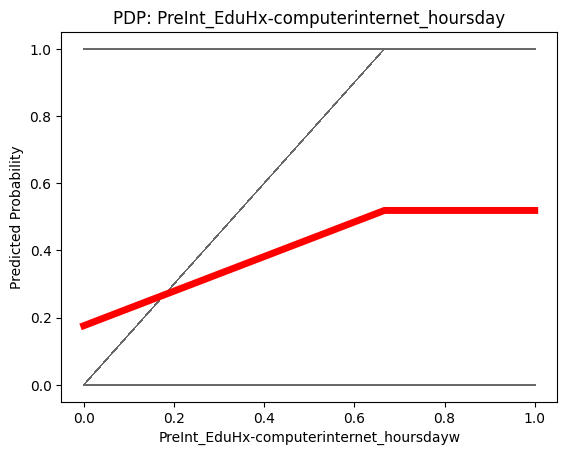

In [ ]:
ice_plot(tmpdf, c='dimgray', linewidth=0.3,
                  plot_pdp=True,
         pdp_kwargs={'linewidth': 5, 'color':'red'})
plt.title('PDP: PreInt_EduHx-computerinternet_hoursday')
plt.ylabel('Predicted Probability')
plt.xlabel('PreInt_EduHx-computerinternet_hoursdayw');
plt.show()

#### Physical-Height

In [ ]:
tmpdf = ice(data = train_X_df,
            column = "Physical-Height",
            predict = clf.predict, #predict from the model
            num_grid_points = train_X_df['Physical-Height'].nunique())

print(np.shape(tmpdf))

(96, 796)


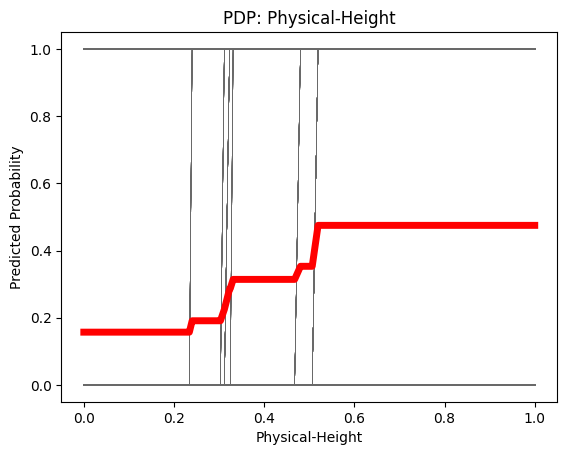

In [ ]:
ice_plot(tmpdf, c='dimgray', linewidth=0.3,
                  plot_pdp=True,
         pdp_kwargs={'linewidth': 5, 'color':'red'})
plt.title('PDP: Physical-Height')
plt.ylabel('Predicted Probability')
plt.xlabel('Physical-Height');
plt.show()

#### relative_date_PCIAT__minimum

In [ ]:
tmpdf = ice(data = train_X_df,
            column = "relative_date_PCIAT__minimum",
            predict = clf.predict, #predict from the model
            num_grid_points = train_X_df['relative_date_PCIAT__minimum'].nunique())

print(np.shape(tmpdf))

(134, 796)


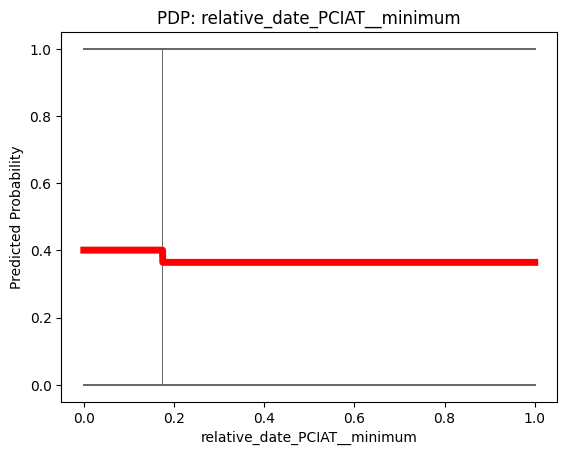

In [ ]:
ice_plot(tmpdf, c='dimgray', linewidth=0.3,
                  plot_pdp=True,
         pdp_kwargs={'linewidth': 5, 'color':'red'})
plt.title('PDP: relative_date_PCIAT__minimum')
plt.ylabel('Predicted Probability')
plt.xlabel('relative_date_PCIAT__minimum');
plt.show()

#### BIA-BIA_LDM

In [ ]:
tmpdf = ice(data = train_X_df,
            column = "BIA-BIA_LDM",
            predict = clf.predict, #predict from the model
            num_grid_points = train_X_df['BIA-BIA_LDM'].nunique())

print(np.shape(tmpdf))

(443, 796)


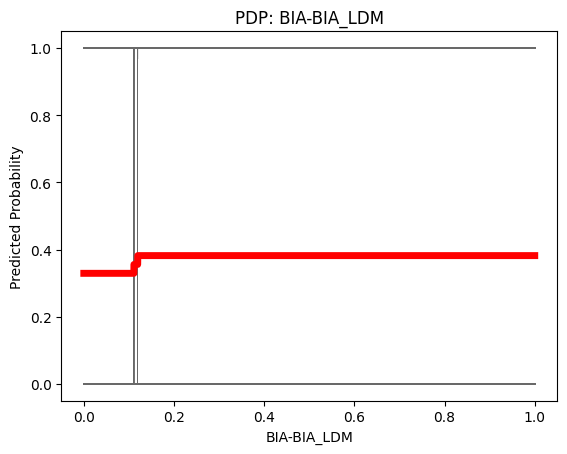

In [ ]:
ice_plot(tmpdf, c='dimgray', linewidth=0.3,
                  plot_pdp=True,
         pdp_kwargs={'linewidth': 5, 'color':'red'})
plt.title('PDP: BIA-BIA_LDM')
plt.ylabel('Predicted Probability')
plt.xlabel('BIA-BIA_LDM');
plt.show()

#### light__maximum

In [ ]:
tmpdf = ice(data = train_X_df,
            column = "light__maximum",
            predict = clf.predict, #predict from the model
            num_grid_points = train_X_df['light__maximum'].nunique())

print(np.shape(tmpdf))

(562, 796)


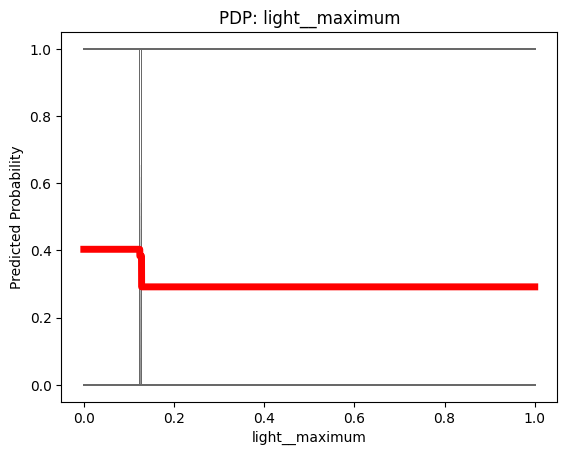

In [ ]:
ice_plot(tmpdf, c='dimgray', linewidth=0.3,
                  plot_pdp=True,
         pdp_kwargs={'linewidth': 5, 'color':'red'})
plt.title('PDP: light__maximum')
plt.ylabel('Predicted Probability')
plt.xlabel('light__maximum');
plt.show()

# Reduced model using important features - BEST PERFORMANCE!!!

I will use the top 20 features of the previous model, identified via the permutation analysis.

In [ ]:
# top 20 important features
top_n = 20
top_features_idx = perm_sorted_idx[-top_n:]

# Filter for plotting
filtered_importances = result.importances[top_features_idx]
filtered_labels = np.array(X_columns)[top_features_idx]

# Look at feature names that are flagged as most important
print(f"Top {top_n} Important Features:")
for label in filtered_labels[::-1]:
  print(label)

Top 20 Important Features:
PreInt_EduHx-computerinternet_hoursday
Physical-Height
relative_date_PCIAT__minimum
BIA-BIA_LDM
light__maximum
Physical-Systolic_BP
SDS-SDS_Total_Raw
Z__minimum
X__sum_values
FGC-FGC_TL
Basic_Demos-Age
weekday__root_mean_square
Z__standard_deviation
anglez__sum_values
FGC-FGC_CU
PAQ_C-Season_Winter
Physical-BMI
X__absolute_maximum
Z__maximum
weekday__mean


In [ ]:
from sklearn.preprocessing import StandardScaler

# Save the top feature names from the previous model
top_20_features = filtered_labels[::-1]  # Reverse to maintain descending order of importance

# Subset the columns in training and testing data
X_train_top_20 = X_train[top_20_features]
X_test_top_20 = X_test[top_20_features]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_top_20)
X_test_imputed = imputer.transform(X_test_top_20)

# Scale the data
scaler = StandardScaler()
X_train_scaled_sub = scaler.fit_transform(X_train_imputed)
X_test_scaled_sub = scaler.transform(X_test_imputed)

# Convert back to DataFrame for easier inspection
X_train_scaled_sub_df = pd.DataFrame(X_train_scaled_sub, columns=top_20_features)
X_test_scaled_sub_df = pd.DataFrame(X_test_scaled_sub, columns=top_20_features)

X_train_scaled_sub_df.head()

,PreInt_EduHx-computerinternet_hoursday,Physical-Height,relative_date_PCIAT__minimum,BIA-BIA_LDM,light__maximum,Physical-Systolic_BP,SDS-SDS_Total_Raw,Z__minimum,X__sum_values,FGC-FGC_TL,Basic_Demos-Age,weekday__root_mean_square,Z__standard_deviation,anglez__sum_values,FGC-FGC_CU,PAQ_C-Season_Winter,Physical-BMI,X__absolute_maximum,Z__maximum,weekday__mean
0,-0.945594,-0.431167,-0.509600,-0.398579,0.259687,-1.011496,1.577185,0.218198,-2.942365,0.400187,-0.392123,0.064794,-0.459532,0.566298,-0.380822,2.202939,-0.168386,0.031060,1.287677,0.086377
1,0.000000,1.091931,0.296913,0.784862,0.298092,0.876532,1.269250,0.246226,1.057157,-0.007717,0.761778,-0.093096,0.552480,0.963276,-0.380822,2.202939,0.620612,5.677052,0.203591,-0.224389
2,1.817368,1.261164,1.587333,0.747609,-2.396251,-0.839857,0.345443,0.224009,0.307807,-0.619574,0.473302,2.357003,0.500122,0.490957,-0.180295,2.202939,0.049943,-1.017624,-0.932975,3.508374
3,-0.945594,-1.683493,-0.509600,-0.927384,0.309855,-1.411987,0.000000,0.179981,-0.250637,0.400187,-1.546024,-0.939346,-1.102048,0.281775,-1.182934,-0.453939,-1.186405,-0.362592,-0.275046,-0.803446
4,-0.945594,-1.378873,-0.578729,-1.316003,0.245019,0.361615,-0.681009,0.215020,0.424164,-0.415622,-0.969074,0.637398,0.189977,0.926853,-1.082670,-0.453939,-0.481975,5.761414,0.179154,0.590663


In [ ]:
print(X_train_scaled_sub_df.shape,
      X_test_scaled_sub_df.shape,
      y_train.shape,
      y_test.shape)

(796, 20) (200, 20) (796, 1) (200, 1)


## Read In Data

In [ ]:
# Save results
# X_train_scaled_sub_df.to_csv('/content/drive/MyDrive/OPIM_5512/model_data/X_train_scaled_sub.csv')
# X_test_scaled_sub_df.to_csv('/content/drive/MyDrive/OPIM_5512/model_data/X_test_scaled_sub.csv')
# y_train.to_csv('/content/drive/MyDrive/OPIM_5512/model_data/y_train.csv')
# y_test.to_csv('/content/drive/MyDrive/OPIM_5512/model_data/y_test.csv')

# Read the saved CSV files back into variables
X_train_scaled_sub_df = pd.read_csv('/content/drive/MyDrive/OPIM_5512/model_data/X_train_scaled_sub.csv')
X_test_scaled_sub_df = pd.read_csv('/content/drive/MyDrive/OPIM_5512/model_data/X_test_scaled_sub.csv')
y_train = pd.read_csv('/content/drive/MyDrive/OPIM_5512/model_data/y_train.csv')
y_test = pd.read_csv('/content/drive/MyDrive/OPIM_5512/model_data/y_test.csv')

In [ ]:
X_train_scaled_sub_df.head()

,Unnamed: 0,PreInt_EduHx-computerinternet_hoursday,Physical-Height,relative_date_PCIAT__minimum,BIA-BIA_LDM,light__maximum,Physical-Systolic_BP,SDS-SDS_Total_Raw,Z__minimum,X__sum_values,...,Basic_Demos-Age,weekday__root_mean_square,Z__standard_deviation,anglez__sum_values,FGC-FGC_CU,PAQ_C-Season_Winter,Physical-BMI,X__absolute_maximum,Z__maximum,weekday__mean
0,0,-0.945594,-0.431167,-0.509600,-0.398579,0.259687,-1.011496,1.577185,0.218198,-2.942365,...,-0.392123,0.064794,-0.459532,0.566298,-0.380822,2.202939,-0.168386,0.031060,1.287677,0.086377
1,1,0.000000,1.091931,0.296913,0.784862,0.298092,0.876532,1.269250,0.246226,1.057157,...,0.761778,-0.093096,0.552480,0.963276,-0.380822,2.202939,0.620612,5.677052,0.203591,-0.224389
2,2,1.817368,1.261164,1.587333,0.747609,-2.396251,-0.839857,0.345443,0.224009,0.307807,...,0.473302,2.357003,0.500122,0.490957,-0.180295,2.202939,0.049943,-1.017624,-0.932975,3.508374
3,3,-0.945594,-1.683493,-0.509600,-0.927384,0.309855,-1.411987,0.000000,0.179981,-0.250637,...,-1.546024,-0.939346,-1.102048,0.281775,-1.182934,-0.453939,-1.186405,-0.362592,-0.275046,-0.803446
4,4,-0.945594,-1.378873,-0.578729,-1.316003,0.245019,0.361615,-0.681009,0.215020,0.424164,...,-0.969074,0.637398,0.189977,0.926853,-1.082670,-0.453939,-0.481975,5.761414,0.179154,0.590663


In [ ]:
X_train_scaled_sub = X_train_scaled_sub_df.drop(columns=['Unnamed: 0'])
X_test_scaled_sub = X_test_scaled_sub_df.drop(columns=['Unnamed: 0'])
y_train = y_train.drop(columns=['Unnamed: 0'])
y_test = y_test.drop(columns=['Unnamed: 0'])

X_train_scaled_sub.head()

,PreInt_EduHx-computerinternet_hoursday,Physical-Height,relative_date_PCIAT__minimum,BIA-BIA_LDM,light__maximum,Physical-Systolic_BP,SDS-SDS_Total_Raw,Z__minimum,X__sum_values,FGC-FGC_TL,Basic_Demos-Age,weekday__root_mean_square,Z__standard_deviation,anglez__sum_values,FGC-FGC_CU,PAQ_C-Season_Winter,Physical-BMI,X__absolute_maximum,Z__maximum,weekday__mean
0,-0.945594,-0.431167,-0.509600,-0.398579,0.259687,-1.011496,1.577185,0.218198,-2.942365,0.400187,-0.392123,0.064794,-0.459532,0.566298,-0.380822,2.202939,-0.168386,0.031060,1.287677,0.086377
1,0.000000,1.091931,0.296913,0.784862,0.298092,0.876532,1.269250,0.246226,1.057157,-0.007717,0.761778,-0.093096,0.552480,0.963276,-0.380822,2.202939,0.620612,5.677052,0.203591,-0.224389
2,1.817368,1.261164,1.587333,0.747609,-2.396251,-0.839857,0.345443,0.224009,0.307807,-0.619574,0.473302,2.357003,0.500122,0.490957,-0.180295,2.202939,0.049943,-1.017624,-0.932975,3.508374
3,-0.945594,-1.683493,-0.509600,-0.927384,0.309855,-1.411987,0.000000,0.179981,-0.250637,0.400187,-1.546024,-0.939346,-1.102048,0.281775,-1.182934,-0.453939,-1.186405,-0.362592,-0.275046,-0.803446
4,-0.945594,-1.378873,-0.578729,-1.316003,0.245019,0.361615,-0.681009,0.215020,0.424164,-0.415622,-0.969074,0.637398,0.189977,0.926853,-1.082670,-0.453939,-0.481975,5.761414,0.179154,0.590663


In [ ]:
important_features = X_train_scaled_sub.columns # save features

In [ ]:
y_train.head()

,sii
0,1.0
1,1.0
2,1.0
3,0.0
4,0.0


## Modeling

In [ ]:
from xgboost import XGBClassifier

clf = XGBClassifier(
    learning_rate=0.1,
    max_depth=5, #increase the depth for improved performance
    min_child_weight=17,
    subsample=0.7,
    random_state=42,

)

# Fit the Model
clf.fit(X_train_scaled_sub, y_train)

# Make predictions
y_pred_train_sub = clf.predict(X_train_scaled_sub)
y_pred_test_sub = clf.predict(X_test_scaled_sub)

### Results

In [ ]:
from sklearn.metrics import confusion_matrix

#train confusion matrix
confusion_matrix(y_train, y_pred_train_sub)

array([[403,  60],
       [ 78, 255]])

In [ ]:
#test confusion matrix
confusion_matrix(y_test, y_pred_test_sub)

array([[100,  20],
       [ 20,  60]])

In [ ]:
# Display the classification report
print("Classification Report - Train:")
print(classification_report(y_train, y_pred_train_sub))
print("\nClassification Report - Test:")
print(classification_report(y_test, y_pred_test_sub))

Classification Report - Train:
              precision    recall  f1-score   support

         0.0       0.84      0.87      0.85       463
         1.0       0.81      0.77      0.79       333

    accuracy                           0.83       796
   macro avg       0.82      0.82      0.82       796
weighted avg       0.83      0.83      0.83       796


Classification Report - Test:
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83       120
         1.0       0.75      0.75      0.75        80

    accuracy                           0.80       200
   macro avg       0.79      0.79      0.79       200
weighted avg       0.80      0.80      0.80       200



It looks like reducing the model complexity, including only important features, improved performance on both the majority and minority class!

In [ ]:
# Prompt: Can you evaluate the optimal threshold based on f1 score?

# The default decision threshold is 0.5. Since
# you want to optimize the F1-score, adjust the
# threshold to find the value that maximizes it.

# Generate prediction probabilities
y_probs = clf.predict_proba(X_test_scaled_sub)[:, 1]

# Optimize the threshold for F1-score
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
optimal_idx = f1_scores.argmax()
optimal_threshold = thresholds[optimal_idx]

print("Optimal Threshold for F1:", optimal_threshold)

# Make predictions with the optimal threshold
y_pred_test_adjusted = (y_probs >= optimal_threshold).astype(int)

# Evaluate the model with the new threshold
print(classification_report(y_test, y_pred_test_adjusted))

Optimal Threshold for F1: 0.5109564
              precision    recall  f1-score   support

         0.0       0.84      0.85      0.84       120
         1.0       0.77      0.75      0.76        80

    accuracy                           0.81       200
   macro avg       0.80      0.80      0.80       200
weighted avg       0.81      0.81      0.81       200



Looks like the optimal threshold is near 0.5, but a 0.5109564 yields an accuracy and weighted f1 score of 0.81! The thresold improves error metrics for both classes in the the test partition.

In [ ]:
# Verify your shape of the train and test partitions to ensure there is no data leakage!
print(X_train_scaled_sub.shape,
      X_test_scaled_sub.shape)

(796, 20) (200, 20)


## Interpretability

### Permutation Importance

Top 5 Important Features:
PreInt_EduHx-computerinternet_hoursday
SDS-SDS_Total_Raw
Physical-Height
light__maximum
Physical-BMI




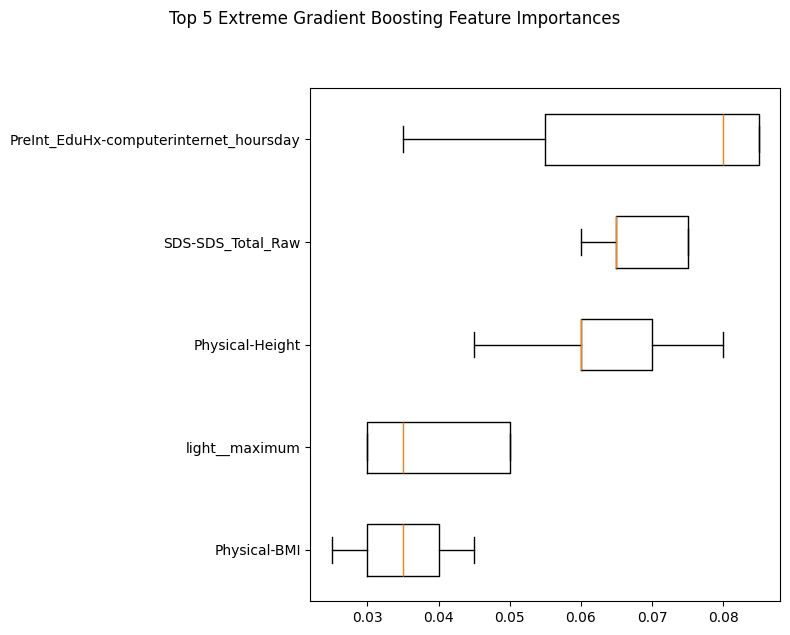

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(clf, X_test_scaled_sub, y_test,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

# Get indices of top 5 important features
top_n = 5
top_features_idx = perm_sorted_idx[-top_n:]  # Last 'top_n' features

# Filter
filtered_importances = result.importances[top_features_idx]
filtered_labels = np.array(important_features)[top_features_idx]

# Look at feature names that are flagged as most important
print(f"Top {top_n} Important Features:")
for label in filtered_labels[::-1]:
  print(label)
print("\n")


# Plot top 5 features
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
ax1.boxplot(filtered_importances.T, vert=False, labels=filtered_labels)
fig.suptitle(f'Top {top_n} Extreme Gradient Boosting Feature Importances', y=1.05)
fig.tight_layout()
plt.show()

# Baseline Demographic only Model

Seeing that many of the important features were demographic, we will fit one last model without merging any accelerometer data to ensure there is valuable information captured therein. We want to ultimately determine if performance can be improved by removing any extra signal or undesirable noise that could be present in the accelerometer data.

In [ ]:
# Read in processed partitioned data IDs and omit mean values
X_train = pd.read_csv('/content/drive/MyDrive/OPIM_5512/X_train_F24_withID.csv', usecols=['id'])
X_test = pd.read_csv('/content/drive/MyDrive/OPIM_5512/X_test_F24_withID.csv', usecols=['id'])
y_train = pd.read_csv('/content/drive/MyDrive/OPIM_5512/y_train_F24_withID.csv', usecols=['id', 'sii'])
y_test = pd.read_csv('/content/drive/MyDrive/OPIM_5512/y_test_F24_withID.csv', usecols=['id', 'sii'])

# Merge the encoded demographic features with X_train based on 'id'
X_train = X_train.merge(train_df_encoded, on='id', how='left')

# Merge the encoded test features with X_test
X_test = X_test.merge(train_df_encoded, on='id', how='left')

X_train.head()

,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,...,PAQ_A-Season_Winter,PAQ_C-Season_Spring,PAQ_C-Season_Summer,PAQ_C-Season_Winter,SDS-Season_Spring,SDS-Season_Summer,SDS-Season_Winter,PreInt_EduHx-Season_Spring,PreInt_EduHx-Season_Summer,PreInt_EduHx-Season_Winter
0,a0522c83,9,0,41.0,18.469705,53.00,73.8,NaN,56.0,71.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,4a4a0f78,13,0,55.0,22.309013,64.25,131.0,NaN,51.0,92.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,a8b0428d,12,0,60.0,19.532102,65.50,119.2,NaN,71.0,73.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,6282e693,5,0,61.0,13.515964,43.75,36.8,20.0,58.0,89.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,a4530b41,7,0,60.0,16.943762,46.00,51.0,NaN,75.0,101.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
#drop IDs for modeling
X_train = X_train.drop(columns=['id'], axis=1)
X_test = X_test.drop(columns=['id'], axis=1)
y_train.drop('id', axis=1, inplace=True)
y_test.drop('id', axis=1, inplace=True)

X_columns = X_train.columns

# Print each column name
print(f"There are {len(X_columns)} demographic variables.")

There are 78 demographic variables.


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scale the data
scaler = MinMaxScaler()
X_train_scaled_demo = scaler.fit_transform(X_train_imputed)
X_test_scaled_demo = scaler.transform(X_test_imputed)

pd.DataFrame(X_train_scaled_demo, columns=X_columns)

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,PAQ_A-Season_Winter,PAQ_C-Season_Spring,PAQ_C-Season_Summer,PAQ_C-Season_Winter,SDS-Season_Spring,SDS-Season_Summer,SDS-Season_Winter,PreInt_EduHx-Season_Spring,PreInt_EduHx-Season_Summer,PreInt_EduHx-Season_Winter
0,0.2500,0.0,0.163934,0.407666,0.363636,0.244048,0.148148,0.335821,0.396396,0.269504,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.5000,0.0,0.393443,0.492407,0.655844,0.433201,0.148148,0.298507,0.585586,0.503546,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.4375,0.0,0.475410,0.431115,0.688312,0.394180,0.148148,0.447761,0.414414,0.290780,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0000,0.0,0.491803,0.298326,0.123377,0.121693,0.037037,0.350746,0.558559,0.219858,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.1250,0.0,0.475410,0.373985,0.181818,0.168651,0.148148,0.477612,0.666667,0.439716,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,0.2500,0.0,0.475410,0.336983,0.324675,0.190476,0.148148,0.440299,0.441441,0.312057,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
792,0.3125,0.0,0.426230,0.433692,0.376623,0.264550,0.148148,0.402985,0.495495,0.219858,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
793,0.7500,0.0,0.491803,0.394820,0.636364,0.339286,0.148148,0.485075,0.450450,0.375887,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
794,0.6250,1.0,0.557377,0.418892,0.629870,0.357143,0.148148,0.574627,0.648649,0.553191,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
from xgboost import XGBClassifier

clf = XGBClassifier(
    learning_rate=0.1,
    max_depth=1,
    min_child_weight=16,
    n_estimators=100,
    n_jobs=1,
    subsample=0.70,
    verbosity=0,
    random_state=42
)

# Fit the Model
clf.fit(X_train_scaled_demo, y_train)

# Make predictions
y_pred_train_demo = clf.predict(X_train_scaled_demo)
y_pred_test_demo = clf.predict(X_test_scaled_demo)

In [ ]:
#train confusion matrix
confusion_matrix(y_train, y_pred_train_demo)

array([[381,  82],
       [115, 218]])

In [ ]:
#test confusion matrix
confusion_matrix(y_test, y_pred_test_demo)

array([[95, 25],
       [35, 45]])

In [ ]:
# Display the classification report
print("Classification Report - Train:")
print(classification_report(y_train, y_pred_train_demo))
print("\nClassification Report - Test:")
print(classification_report(y_test, y_pred_test_demo))

Classification Report - Train:
              precision    recall  f1-score   support

         0.0       0.77      0.82      0.79       463
         1.0       0.73      0.65      0.69       333

    accuracy                           0.75       796
   macro avg       0.75      0.74      0.74       796
weighted avg       0.75      0.75      0.75       796


Classification Report - Test:
              precision    recall  f1-score   support

         0.0       0.73      0.79      0.76       120
         1.0       0.64      0.56      0.60        80

    accuracy                           0.70       200
   macro avg       0.69      0.68      0.68       200
weighted avg       0.70      0.70      0.70       200



In [ ]:
# Verify your shape of the train and test partitions to ensure there is no data leakage!
print(X_train_scaled_demo.shape,
      X_test_scaled_demo.shape)

(796, 78) (200, 78)


Looks like there is valuable information contained in the times series data as there is a significant performance drop!

# Model Story

The plots below illustrate the distributions of the top five most important features identified by the best performing reduced model. SHAP analysis provides insights into how these features influence the model's predictions. Since the reduced model achieved the best performance, SHAP was applied to it for interpretability.

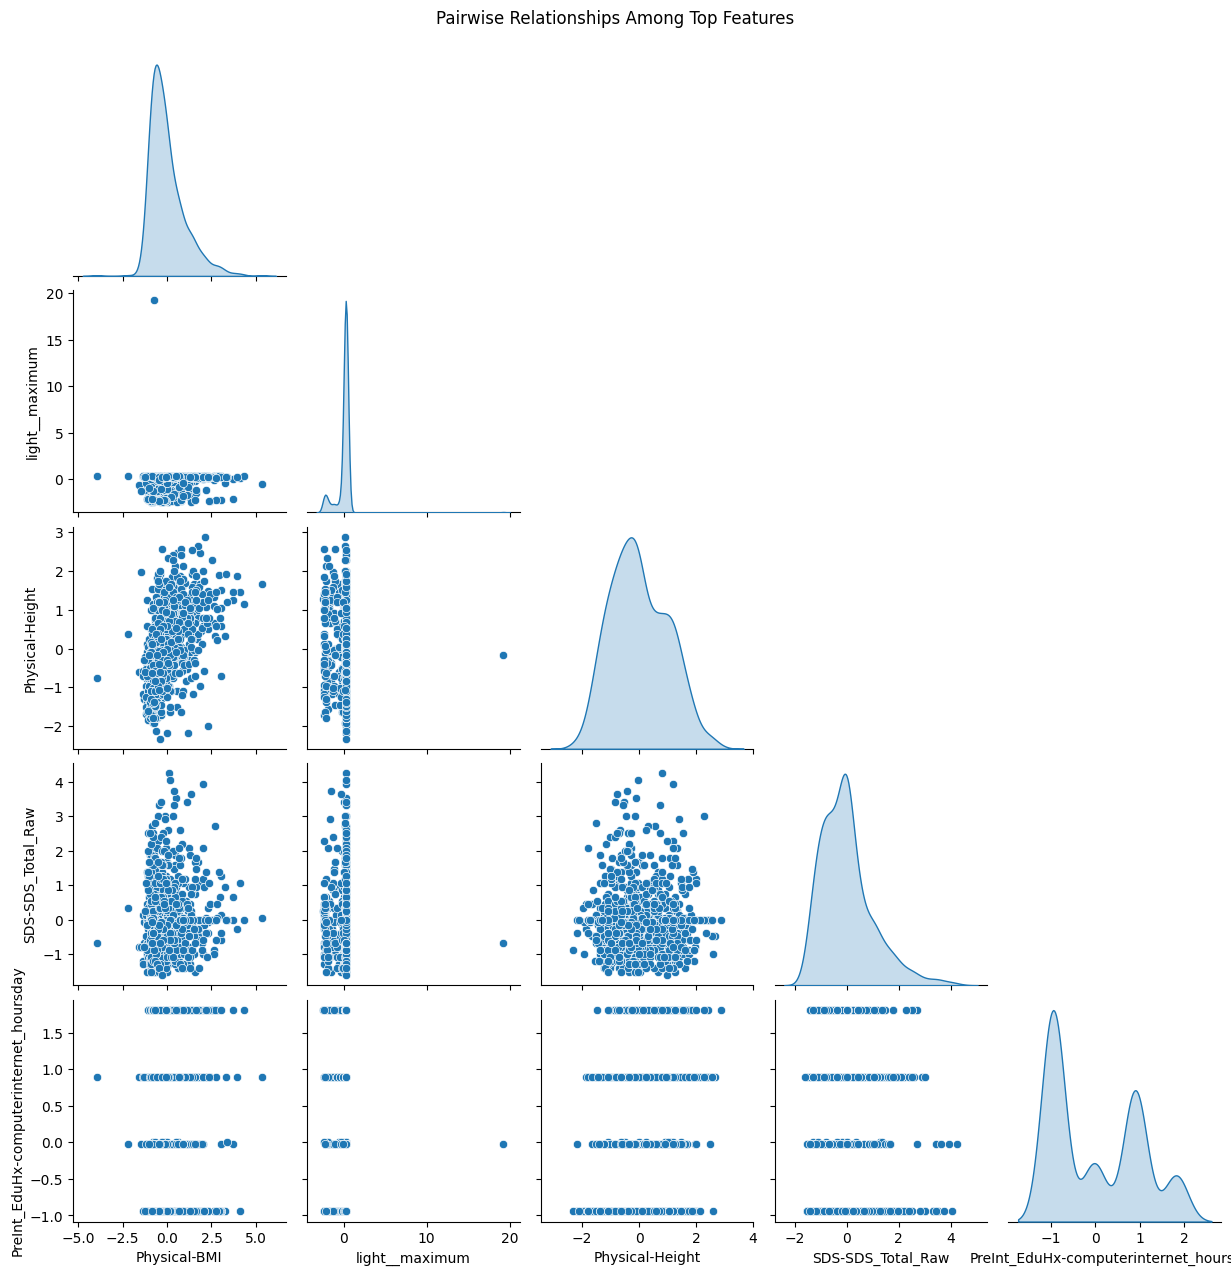

In [ ]:
X_train_scaled_sub = pd.DataFrame(X_train_scaled_sub, columns=important_features)

# Filter the data to only include the top features
filtered_data = X_train_scaled_sub[filtered_labels]

# Use a subset of important features for pairplot
pairplot_features = filtered_data.iloc[:, :5]

sns.pairplot(pairplot_features, diag_kind='kde', corner=True)
plt.suptitle("Pairwise Relationships Among Top Features", y=1.02)
plt.show()

https://medium.com/@kishanakbari/understanding-shap-values-unlocking-interpretability-in-machine-learning-ee1f4a9b3a8c

This is a great beginner article about SHAPs!

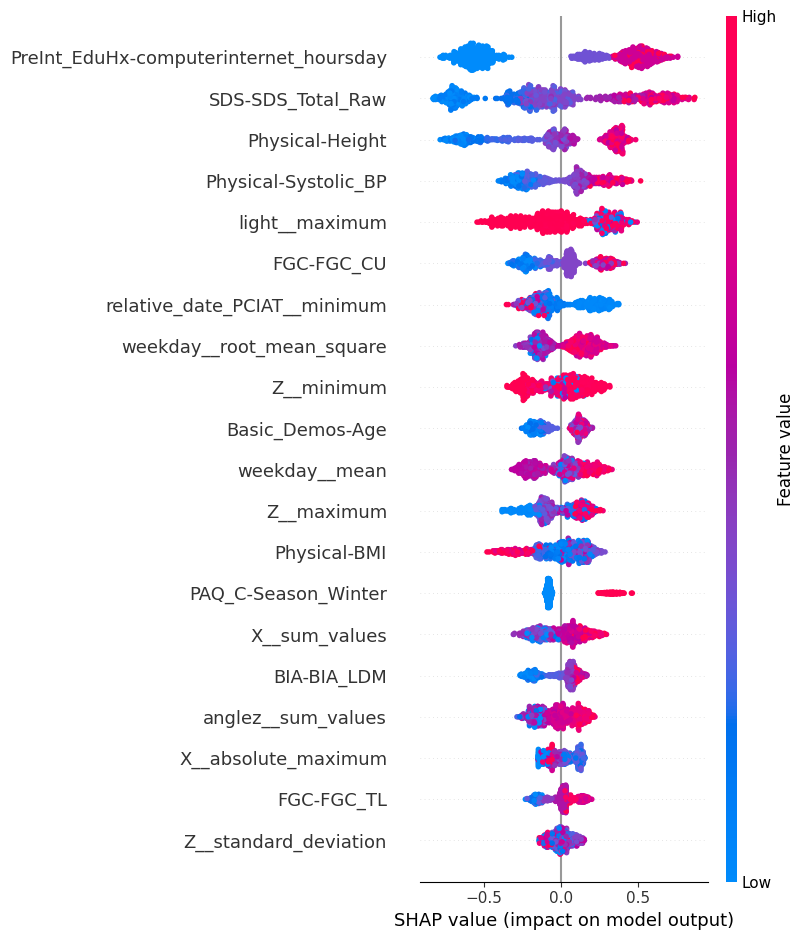

In [ ]:
import shap

# Initialize the explainer
explainer = shap.Explainer(clf, X_train_scaled_sub)
shap_values = explainer(X_train_scaled_sub)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_train_scaled_sub)

Analyzing the distributions of the important features, their partial dependence plots, and the SHAP analysis reveals how the model is predicting in a way that is both interesting and somewhat intuitive. For instance, higher values of `PreInt_EduHx-computerinternet_hoursday` likely lead to higher predicted probability. Similarly, `SDS-SDS_Total_Raw`—the total score for sleep disorders in children—has a comparable impact on predictions. These two features appear to be the most significant in influencing the response variable `SII`.

A few physical variables appear to influence predictions, which is intriguing. Health features like blood pressure are somewhat intuitive; individuals who are generally unhealthy and have high systolic blood pressure might exhibit problematic internet usage. However, this connection feels like a significant assumption. On the other hand, height is not intuitive at all, leaving us questioning why taller individuals are predicted to have a higher probability.

Based on our plots and analyses, individuals with high internet usage are more likely to exhibit problematic internet use. Individuals with sleep disorders may be using the internet as a coping mechanism or further disrupting their sleep patterns. While less direct or significant, `BIA-BIA_LDM` might be correlated with overall health and well-being, which could indirectly influence internet use.

We are uncertain about `relative_date_PCIAT_minimum` and `Physical-Height`. We hypothesize that individuals who recently took the `Parent-Child Internet Addiction Test` might be more keen to their internet use and potentially taking steps to reduce it. However, we are ultimately uncertain.


# Business Recommendation

We recommend the inclusion of detailed time series data to predict problematic internet usage (`SII`). Analyzing the performance of various models revealed that incorporating both demographic data and engineered time series variables yielded the highest accuracy. The significance of time series data was highlighted by a performance drop off when only demographic data was included in the modeling process. Specifically, the demographic only model achieved an accuracy of approximately 70%, which was an improvement over the baseline accuracy of 60% from the starter code. The starter code utilized only mean feature-engineered columns from the parquet files without demographic information. However, introducing and merging the TSFresh minimal engineered features—deriving 130 features from the parquet files—boosted the best model accuracy to 73%. While this "kitchen sink" approach to inputs improved accuracy, we explored whether a reduced model could yield better error metrics.

Through permutation importance and partial dependence plots, we identified the most impactful features for predicting `SII`:

*   `PreInt_EduHx-computerinternet_hoursday`
*   `Physical-Height`
*   `relative_date_PCIAT__minimum`
*   `BIA-BIA_LDM`
*   `light__maximum`

By leveraging key variance from a few engineered features, along with a smaller subset of demographic features, we achieved our best accuracy (80%) and weighted F1 score (0.80) using the Extreme Gradient Boosting Classifier. However, a modified threshold of approximately 0.511 yields an accuracy and f1 score of 0.81. Additionally, two more features—`SDS-SDS_Total_Raw`, `Physical-BMI`—emerged as significant during the permutation importance analysis of the latter reduced model.

Our recommendation is to include the 20 most important features listed below, which combine a subset of both demographic and feature-engineered time series data:

In [ ]:
for feature_index, feature in enumerate(important_features, start=1):
  print(f"{feature_index}: {feature}")

1: PreInt_EduHx-computerinternet_hoursday
2: Physical-Height
3: relative_date_PCIAT__minimum
4: BIA-BIA_LDM
5: light__maximum
6: Physical-Systolic_BP
7: SDS-SDS_Total_Raw
8: Z__minimum
9: X__sum_values
10: FGC-FGC_TL
11: Basic_Demos-Age
12: weekday__root_mean_square
13: Z__standard_deviation
14: anglez__sum_values
15: FGC-FGC_CU
16: PAQ_C-Season_Winter
17: Physical-BMI
18: X__absolute_maximum
19: Z__maximum
20: weekday__mean


# Conclusion

1.   ***The value of a pre-modeling correlation analysis***: One of the key lessons learned from the project, particularly in light of the high accuracy results achieved with our initial models—a test weighted f1-score of 0.94 and 1 for train—is the risk of overfitting when features are highly correlated with the target variable. In our case, the Kaggle documentation highlighted a potential overfitting issue with the parent-child internet addiction test (`PCIAT`) note:

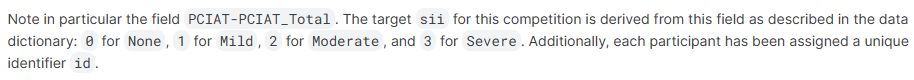

It is our position that the `PCIAT` survey questions, irrespective of the total score (`PCIAT-PCIAT_Total`), are overall the best indicators for our response variable `SII`. The 0.94 weighted f1-score was achieved by removing the total and preserving the original 20 survey questions.

In [ ]:
print(high_correlation) #variables with high correlation to SII

sii                  1.000000
PCIAT-PCIAT_Total    0.899681
PCIAT-PCIAT_15       0.751399
PCIAT-PCIAT_18       0.731112
PCIAT-PCIAT_17       0.729867
PCIAT-PCIAT_05       0.722722
PCIAT-PCIAT_13       0.705679
PCIAT-PCIAT_20       0.703013
PCIAT-PCIAT_16       0.698566
PCIAT-PCIAT_08       0.695458
PCIAT-PCIAT_03       0.694736
PCIAT-PCIAT_02       0.694597
PCIAT-PCIAT_10       0.689972
PCIAT-PCIAT_19       0.683293
PCIAT-PCIAT_14       0.675953
PCIAT-PCIAT_09       0.660485
PCIAT-PCIAT_06       0.645596
PCIAT-PCIAT_01       0.617883
PCIAT-PCIAT_11       0.609964
Name: sii, dtype: float64


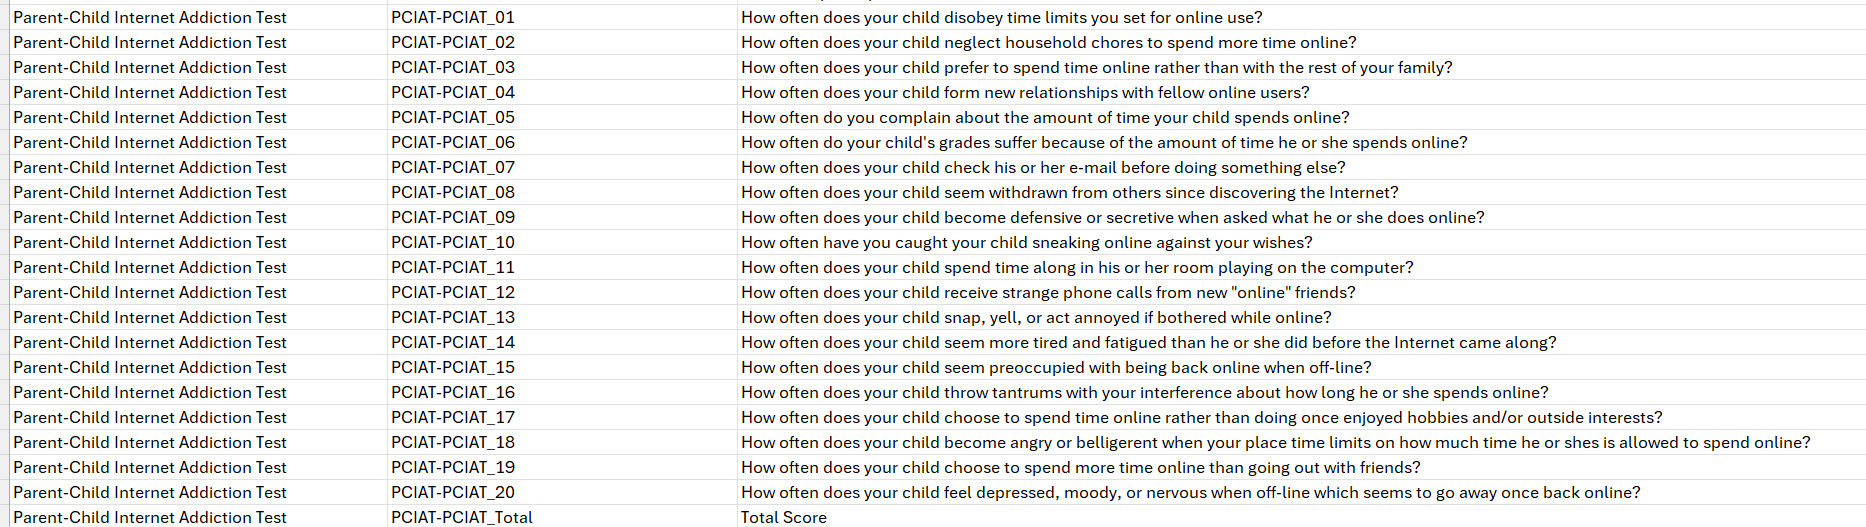

This high correlation with questions such as `PCIAT_15` (***“How often does your child seem preoccupied with being back online when offline?”***) and `PCIAT_18` (***“How often does your child become angry or belligerent when you place time limits on how much time they are allowed to spend online?”***) lead to the high predictive performance. This may have resulted in a potentially misleading performance measure on the test set, which might not generalize well if those questions were unavailable in new/unseen data. Removing the `PCIAT` questions revealed how truly challenging it is to accurately predict `SII` without direct user responses.

This project underscored the importance of feature selection and highlighted the potential to address some of this selection during the EDA process by checking feature correlations for potential removal to avoid data leakage. Removing all `PCIAT` variables likely mitigated overfitting, resulting in more robust results and a more reliable test of the model's actual performance on unseen data.
2.   ***Feature engineering to enhance model precision***: The implementation of the TSFresh minimum features extraction, which derived 130 unique features from the time-series accelerometer data, ultimately enriched our model's predictions. This is emphasized by the inclusion of several feature-engineered variables identified as important in the construction of our best-performing model (weighted f1-score of 0.80). These features played a crucial role in capturing the complex patterns within the time-series data, with valuable variance that improved predictions for both the minority and majority classes. Using only the column means of the original 12 accelerometer variables did not yield an accurate model. However, combining demographic features with the engineered features provided notably improved predictions, as it incorporated more nuanced and subtle information from the dataset.
3.   ***Deepening of model insights and refinement***: Analysis of demographic data revealed important patterns and interactions that informed the construction of our predictive classification model. This deeper exploration enabled us to focus on specific demographic variables that significantly influenced problematic internet use scores. By intertwining the EDA performed on the demographic information with the parquet files, we developed a tailored approach to our modeling process. This approach captured variability between groups with greater precision, enhancing the model’s effectiveness while also making it easier to handle and interpret. The integration of these insights not only refined our understanding of the data but also improved the overall robustness of our predictive framework.
4.   ***Feature selection using model interpretability analysis***: By leveraging permutation importance, partial dependence plots, and SHAP values to investigate and understand the model, we were able to simplify and improve the f1-scores for both the majority and minority class predictions in the test set, with minimal drop-off from the training partition. This insight is invaluable, as it allows for more efficient resource utilization; time previously spent on excessive modeling can instead be reallocated to other critical stages of the data science process. Our use of permutation importance analysis was instrumental in identifying the most influential features contributing to `SII`. The interpretability techniques highlighted a mix of demographic and engineered time-series features, such as the hours spent using computers/internet (`PreInt_EduHx`) and the scale categorizing sleep disorders in children (`SDS_Total_Raw`), confirming their importance in the model’s predictions. Partial dependence and SHAP plots provided visual insights into how feature values impacted the model’s decision-making process. These tools not only clarified the inner workings of the often-perceived black box nature of machine learning models but also equipped us with robust techniques for interpreting their predictions. As data scientists, our value lies in analyzing and synthesizing insights from these visualizations to refine and improve our models, but also in communicating the model results to nontechnical stakeholders.
5.   ***The impact of model simplification***: Simplifying the model led to more precise results, as demonstrated by the confusion matrices and classification reports for the top 20 features model. Reducing the number of model inputs from 208 to 20 boosted precision, recall, and f1-scores for both the minority and majority classes, ultimately increasing overall accuracy from 73% to 80%. A simplified model in this case not only enhances performance but also reduces complexity, making the results more interpretable for data scientists, but more importantly, business stakeholders. Additionally, it lowers the cost and effort required to manage the model, aligning technical efficiency with practical business needs while mitigating the challenges of a black-box approach with tree-based models.






